In [1]:
%matplotlib widget

import ipywidgets as widgets
from ipywidgets import HBox, VBox, jslink, Box, Layout
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from scipy.signal import TransferFunction, bode, lsim
from scipy import signal
import control.matlab as control
from IPython.display import Math, display

In [2]:
def make_box_layout():
     return widgets.Layout(
        border='solid 1px black',
        margin='0px 10px 10px 0px',
        padding='5px 5px 5px 5px'
     )

# Vergleich Einstellregeln

## System 2. Ordnung

\begin{align*}
    G_\mathrm{S} &= \frac{1}{(1 + 2 \, s) \, (1 + 0.007 \, s)}
\end{align*}

In [3]:
T1 = 2
T2 = 0.007
sys = signal.lti([1], [T1 * T2, T1 + T2, 1])

## Polkompensation

In [4]:
TN = (T1 + T2)
TV = T1 * T2 / (T1 + T2)
KP = 2

In [7]:
f = np.logspace(-2, 5)
sys = control.tf([1], [T1 * T2, T1 + T2, 1])
mag, phase, w = control.bode(sys, f, plot = False)

reg = control.tf([KP * T1 * T2, KP * (T1 + T2), KP], [T1 + T2, 0])
magReg, phaseReg, wReg = control.bode(reg, f, plot = False)


G0 = sys * reg
magG0, phaseG0, wG0 = control.bode(G0, f, plot = False)

GW = G0 / (1 + G0)
magGW, phaseGW, wGW = control.bode(GW, f, plot = False)


C:\WPy64-31050\python-3.10.5.amd64\lib\site-packages\control\timeresp.py:935: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  warnings.warn(


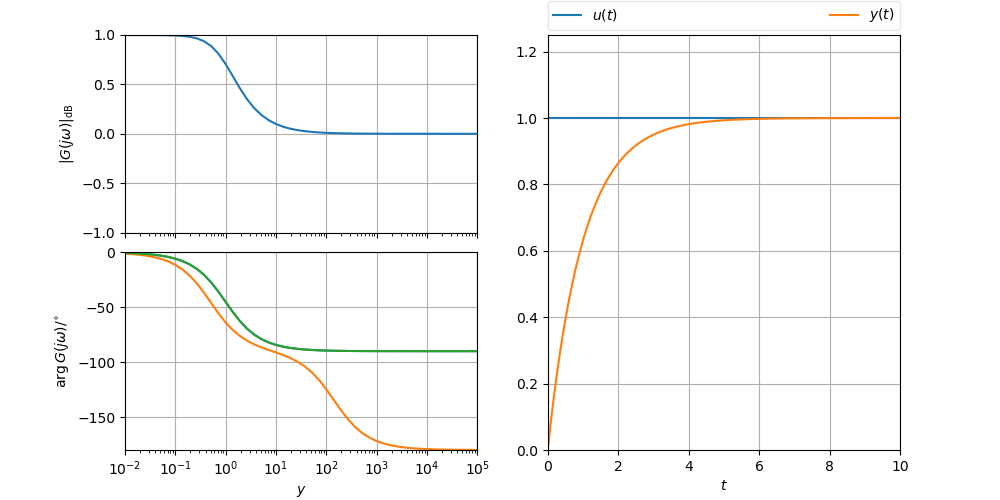

In [8]:
output = widgets.Output()

with output:
    fig = plt.figure(figsize=(10, 5))
    ax3 = plt.subplot(122)
    ax1 = plt.subplot(221)
    ax2 = plt.subplot(223)

plt.subplots_adjust(wspace=0.2, hspace=0.1)
fig.canvas.toolbar_visible = False
fig.canvas.header_visible = False
fig.canvas.footer_visible = False
fig.subplots_adjust(bottom=0.1, top=0.93, left=0.125, right=0.9)

ax1.grid() 
ax2.grid()
ax3.grid()
[label.set_visible(False) for label in ax1.get_xticklabels()]
ax2.set_xlabel(r"$y$")
ax3.set_xlabel(r"$t$")
ax1.set_ylabel(r"$|G(j \omega)|_{\mathrm{dB}}$")
ax2.set_ylabel(r"$\mathrm{arg}\, G(j\omega)/^{\circ}$")
#ax3.set_ylim([-1.1, 1.1])

#ax1.semilogx(w, mag)
#ax1.semilogx(wGW, magGW)
magCLPlot, = ax1.semilogx([], [])
phaseCLPlot, = ax2.semilogx([], [])
ax2.semilogx(w, np.rad2deg(phase))
ax2.semilogx(wGW, np.rad2deg(phaseGW))
simInputPlot, = ax3.plot([], [], label=r'$u(t)$')
simOutputPlot, = ax3.plot([], [], label=r'$y(t)$')

handlesAx, labelsAx = ax3.get_legend_handles_labels()
fig.legend([handle for i, handle in enumerate(handlesAx)],
           [label for i, label in enumerate(labelsAx)],
           bbox_to_anchor=(0.5475, 0.94, 0.3525, .15), loc=3,
           ncol=2, mode="expand", borderaxespad=0., framealpha=0.5)

sliderFreq = widgets.FloatSlider(value=2,
                                    min=0.1,
                                    max=25,
                                    step=0.5,
                                    description='Kp')

def calcSystem(_):
    KP = sliderFreq.value
    
    reg = control.tf([KP * T1 * T2, KP * (T1 + T2), KP], [T1 + T2, 0])
    #magReg, phaseReg, wReg = control.bode(reg, f, plot = False)
    G0 = sys * reg
    magG0, phaseG0, wG0 = control.bode(G0, f, plot = False)

    GW = G0 / (1 + G0)
    magGW, phaseGW, wGW = control.bode(GW, f, plot = False)
    
    magCLPlot.set_data(wGW, magGW)
    phaseCLPlot.set_data(wGW, np.rad2deg(phaseGW))
    
    t = np.linspace(0, 10, 1001)
    u = np.ones(t.size)
    tSim, ySim, xSim = control.lsim(GW, U=u, T=t)
        
    simInputPlot.set_data(t, u)
    simOutputPlot.set_data(ySim, tSim)
    ax3.set_xlim([0, t[-1]])
    ax3.set_ylim([0, 1.25])
    ax1.set_xlim([wGW[0], wGW[-1]])
    ax2.set_xlim([wGW[0], wGW[-1]])
    ax1.set_ylim([-1, 1])
    ax2.set_ylim([-180, 0])
    fig.canvas.draw()

sliderFreq.observe(calcSystem, names='value')

calcSystem(_)

inputControls = Box([sliderFreq])
inputControls.layout = make_box_layout()

HBox([inputControls, output], layout=Layout(display='flex', flex_flow='row', justify_content='center', align_items='center'))#